# Continous Control w/ Deep RL: Deep Deterministic Policy Gradients (DDPG)

The implementation is based on *CONTINUOUS CONTROL WITH DEEP REINFORCEMENT
LEARNING* by Lillicrap and Hunt et al: https://arxiv.org/pdf/1509.02971.pdf.

## Set up

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Some Hyperparameters

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
print(num_agents)

action_size = brain.vector_action_space_size
print(action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print(state_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Hyperparameters
batch_size = 128
seed = 3
buffer_size = int(1e5)
update_every = 1
gamma = 0.99 # discount
tau = 0.001
actor_learning_rate = 1e-4
critic_learning_rate = 1e-4
critic_weight_decay = 0
fc1_dim = 256
fc2_dim = 128

20
4
33
cpu


## Class Definitions

In [11]:
# Actor - Policy
class Actor(nn.Module):
    def __init__(self, action_size, state_size, seed, fc1_dim=400, fc2_dim=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim, fc2_dim)
        self.output = nn.Linear(fc2_dim, action_size)
#         self.batch_norm1 = nn.BatchNorm1d(state_size)
#         self.batch_norm2 = nn.BatchNorm1d(fc1_dim)
#         self.batch_norm3 = nn.BatchNorm1d(fc2_dim)
        self.tanh = nn.Tanh()
        self.reset_parameters(fc1_dim, fc2_dim)
        
    def reset_parameters(self, fc1_dim, fc2_dim):
        self.fc1.weight.data.uniform_(-1./math.sqrt(fc1_dim), 1./math.sqrt(fc1_dim))
        self.fc2.weight.data.uniform_(-1./math.sqrt(fc2_dim), 1./math.sqrt(fc2_dim))
        self.output.weight.data.uniform_(-3e-3, 3e-3)
        self.output.bias.data.uniform_(3e-4, 3e-4)
        
    def forward(self, states):
        x = states
#         x = self.batch_norm1(x)
        x = F.relu(self.fc1(x))
#         x = self.batch_norm2(x)
        x = F.relu(self.fc2(x))
#         x = self.batch_norm3(x)
        return self.tanh(self.output(x))

actor = Actor(action_size, state_size, seed, fc1_dim, fc2_dim)
actor_target = Actor(action_size, state_size, seed, fc1_dim, fc2_dim)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=actor_learning_rate)

In [12]:
# Critic - Q Value
class Critic(nn.Module):
    def __init__(self, action_size, state_size, seed, fc1_dim=400, fc2_dim=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim+action_size, fc2_dim)
        self.output = nn.Linear(fc2_dim, 1)
#         self.batch_norm1 = nn.BatchNorm1d(state_size)
#         self.batch_norm2 = nn.BatchNorm1d(fc1_dim)
        self.reset_parameters(fc1_dim, fc2_dim+action_size)
        
    def reset_parameters(self, fc1_dim, fc2_dim):
        self.fc1.weight.data.uniform_(-1./math.sqrt(fc1_dim), 1./math.sqrt(fc1_dim))
        self.fc2.weight.data.uniform_(-1./math.sqrt(fc2_dim), 1./math.sqrt(fc2_dim))
        self.output.weight.data.uniform_(-3e-3, 3e-3)
        self.output.bias.data.uniform_(3e-4, 3e-4)
        
    def forward(self, states, actions):
        xs = states
#         xs = self.batch_norm1(xs)
        xs = F.relu(self.fc1(xs))
#         xs = self.batch_norm2(xs)
        x = torch.cat((xs, actions), dim=1)
        x = F.relu(self.fc2(x))
        return self.output(x)

critic = Critic(action_size, state_size, seed, fc1_dim, fc2_dim)
critic_target = Critic(action_size, state_size, seed, fc1_dim, fc2_dim)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=critic_learning_rate,
                                    weight_decay=critic_weight_decay)

In [13]:
# ReplayBuffer
from collections import namedtuple, deque
import random

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
memory = ReplayBuffer(action_size, buffer_size, batch_size, seed, device)

In [14]:
# Noise
import copy
import numpy as np
import random

class OrnsteinUhlenbeckNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.size = size
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    
noise = OrnsteinUhlenbeckNoise((num_agents, action_size), seed)

In [15]:
# DDPGAgent
class DDPGAgent:
    def __init__(self, actor_local, actor_target, actor_optimizer,
                 critic_local, critic_target, critic_optimizer, noise, memory,
                 batch_size, num_agents, update_every=2, gamma=0.99, tau=5e-4):
        """Initialize all parameters."""
        self.actor_local = actor_local
        self.actor_target = actor_target
        self.actor_optimizer = actor_optimizer
        
        self.critic_local = critic_local
        self.critic_target = critic_target
        self.critic_optimizer = critic_optimizer
        
        self.noise = noise
        self.memory = memory

        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.num_agents = num_agents
        
        self.t_step = 0
        self.update_every = update_every
        
    def reset(self):
        self.noise.reset()
        
    def act(self, states, device, train_mode=False):
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        if train_mode:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        for i in range(self.num_agents):
            self.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Update Critic
        next_actions = self.actor_target(next_states)
        q_targets_next = self.critic_target(next_states, next_actions)
        q_targets = rewards + (self.gamma * q_targets_next * (1 - dones))
        q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(q_expected, q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Update Actor
        actions_expected = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_expected).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.actor_local, self.actor_target, self.tau)
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
agent = DDPGAgent(actor, actor_target, actor_optimizer, critic, critic_target, critic_optimizer, noise, memory,
                  batch_size, num_agents, update_every, gamma, tau)

## Train DDPG w/o Batch Norm

In [16]:
# train - benchmark
n_episodes = 1000
all_scores = []
scores_window = deque(maxlen=100)

for i_episode in range(1, n_episodes+1):

    agent.reset()
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations           
    scores = np.zeros(num_agents)

    while True:
        actions = agent.act(states, device, train_mode=True)
        env_info = env.step(actions)[brain_name]
        rewards = env_info.rewards
        next_states = env_info.vector_observations
        dones = env_info.local_done

        agent.step(states, actions, rewards, next_states, dones)

        scores += rewards
        states = next_states

        if np.any(dones):  # exit loop if episode finished  
            break

    avg_score = np.mean(scores)
    scores_window.append(avg_score)
    all_scores.append(avg_score)

    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=30.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        break 


Episode 100	Average Score: 27.79
Episode 107	Average Score: 30.29
Environment solved in 7 episodes!	Average Score: 30.29


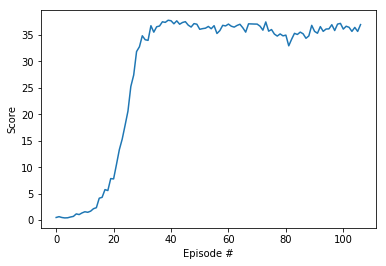

In [17]:
# Benchmark implementation - full iterations

import matplotlib.pyplot as plt
%matplotlib inline

# 60 - score min 5
scores = all_scores

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Train DDPG with Batch norm

1. First, uncomment the commented out lines of code above
2. Then, run the following code to train

In [8]:
# train = benchmark + batch norm
n_episodes = 1000
all_scores = []
scores_window = deque(maxlen=100)

for i_episode in range(1, n_episodes+1):

    agent.reset()
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations           
    scores = np.zeros(num_agents)

    while True:
        actions = agent.act(states, device, train_mode=True)
        env_info = env.step(actions)[brain_name]
        rewards = env_info.rewards
        next_states = env_info.vector_observations
        dones = env_info.local_done

        agent.step(states, actions, rewards, next_states, dones)

        scores += rewards
        states = next_states

        if np.any(dones):  # exit loop if episode finished  
            break

    avg_score = np.mean(scores)
    scores_window.append(avg_score)
    all_scores.append(avg_score)

    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=30.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        break 


Episode 100	Average Score: 22.85
Episode 123	Average Score: 30.07
Environment solved in 23 episodes!	Average Score: 30.07


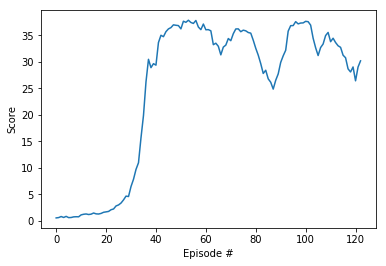

In [9]:
# Benchmark + Batch norms applied - full iterations

import matplotlib.pyplot as plt
%matplotlib inline

# 60 - score min 5
scores = all_scores

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Appendix: Results of training on the original DDPG cited at the top.

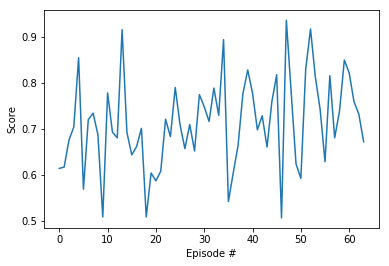

In [9]:
# Exact implementation of the paper
# Benchmark + Batch norm + Critic LR increased + Dims increased + Weight decay increased + Batch size decreased

import matplotlib.pyplot as plt
%matplotlib inline

# 60 - score min 5
scores = all_scores

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Test-run for Visualization

In [21]:
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, device, train_mode=False) # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 39.443999118357894


## Shutdown the environment

In [10]:
env.close()